In [1]:
# !pip install langchain
# !pip install openai -U
# !pip install nervaluate
# !pip install faiss
# !pip install tiktoken
# !pip install pandas
# !pip install sentence-transformers
# !pip install matplotlib

In [2]:
### THE OVERVIEW: 
# 1. Prompt in LLM.
# 2. Convert the receipt text structured data
# 3. Use labels and K-nearest neighbors (embeddings) to classify the vendor into vendor categories.
# 4. Classify the items into categories; propose your own .
# 5. Plot these analytics of vendors and items.

In [3]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from nervaluate import Evaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

# Language Model Integration with Langchain

In [4]:
prompt = """
Can you please convert this unstructured receipt text data into a structured JSON object which includes ReceiptInfo and ITEMS.
Note that sometimes the quantity for an item may be located next to the item name.
Text in the structured JSON should appear in the same format as the unstructured receipt.
Please just give the structured JSON object and nothing else.

Here is the schema for the JSON object:
{{
  "ReceiptInfo": {{
    "merchant": "(string value)",
    "address": "(string value)",
    "city": "(string value)",
    "state": "(string value)",
    "phoneNumber": "(string value)",
    "tax": "(float value)",
    "total": "(float value)",
    "receiptDate": "(string value)",
    "receiptTime": "(string value)",


    "ITEMS": [
      {{
        "description": "(string value)",
        "quantity": "(integer value)",
        "unitPrice": "(float value)",
        "totalPrice": "(float value)",
        "discountAmount": "(float value)"
      }}
    ]
  }}
}}


Examples:

Receipt:
Give us feedback @ <UNKNOWN>
Thank you! ID <UNKNOWN> <UNKNOWN>
Walmart
301-604-0180 Mgr:DEBRA
3549 RUSSETT GRN
LAUREL MD 20724
ST# 01985 OP# 009049 TE# 49 TR# 04345
<UNKNOWN> PRK SB 008265754333 F
1.98 X
BOOSTER
088439295372
19.98 N
VOIDED BANKCARD TRANSACTION
TERMINAL <UNKNOWN> SC010112
TRANSACTION NOT COMPLETE
07/04/23
16:19:53
<UNKNOWN> BANKCARD TRANSACTION
TERMINAL # SC010112
TRANSACTION <UNKNOWN> COMPLETE
07/04/23
16:20:01
SUBTOTAL
21.96
TAX 1
6.000 %
0.12
TOTAL
22.08
VISA TEND
22.08
ACCOUNT #
**** **** <UNKNOWN> 2130 F
APPROVAL # 00592D
REF # 318500762875
TRANS ID - 583185732192035
VALIDATION - B339
PAYMENT SERVICE - E
TERMINAL # SC010112
07/04/23
16:20:21
CHANGE DUE
0.00
# ITEMS SOLD 2
<UNKNOWN> 0069 6254 8220 4557 9869
Walmart
Become a member
Scan for free 30-day trial
Low Prices You Can <UNKNOWN> Every <UNKNOWN>
07/04/23
16:20:22
***CUSTOMER <UNKNOWN>

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "Walmart",
    "address": "3549 RUSSETT GRN",
    "city": "LAUREL",
    "state": "MD",
    "phoneNumber": "301-604-0180",
    "tax": "0.12",
    "total": "22.08",
    "receiptDate": "07/04/23",
    "receiptTime": "4:20pm",


    "ITEMS": [
      {{
        "description": "PRK SB",
        "quantity": "1",
        "unitPrice": "1.98",
        "totalPrice": "1.98",
        "discountAmount": "0.00"
      }},
      {{
        "description": "BOOSTER",
        "quantity": "1",
        "unitPrice": "19.98",
        "totalPrice": "19.98",
        "discountAmount": "0.00"
      }}
    ]
  }}
}}

Receipt:
Unstructured Receipt Text Data:
203
BUY ONE GET ONE FREE QUARTER POUNDER
W/CHEESE OR EGG MCMUFFIN
Go to www.mcdvoice.com within 7 days
and tell <UNKNOWN> about your visit.
Validation Code:
Expires 30 days after receipt date.
Valid at participating US
Survey Code:
<UNKNOWN>
McDonald's Restaurant <UNKNOWN>
2915 E MANCA RD
<UNKNOWN> 96822
TEL# <UNKNOWN>
Thank You Valued Customer
KS# 2
08/19/2023 03:33 PM
<UNKNOWN>
Order 03
1 Happy Meal Ch Burger
5.89
1 Cheeseburger
ONLY Onions
ONLY Ketchup
1 Extra Kids Fry
1 Apple Juice
1 NERF
Subtotal
5.89
Tax
0.28
Take-Out Total
6.17
Cashless
6.17
Change
0.00
MER# 467782
CARD ISSUER
ACCOUNT
Visa SALE
<UNKNOWN> <UNKNOWN> 130
TRANSACTION AMOUNT
6.17
CONTACTLESS
AUTHORIZATION CODE - <UNKNOWN>
SEQ# 107204
AID: A0000000031010
McDonald's Restaurant
Sign up for MyMcDonald's rewards
to earn points on future visit

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "McDonald's Restaurant",
    "address": "2915 E MANOA RD",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "",
    "tax": "0.28",
    "total": "6.17",
    "receiptDate": "08/19/2023",
    "receiptTime": "03:33 PM",


    "ITEMS": [
      {{
        "description": "Happy Meal Ch Burger",
        "quantity": "1",
        "unitPrice": "5.89",
        "totalPrice": "5.89",
        "discountAmount": "0.00"
      }}
    ]
  }}
}}

Receipt:
Unstructured Receipt Text Data:
H
<UNKNOWN>
MART
http://www.hmart.com
458 Keawe st
Honolulu, <UNKNOWN> 96813
TEL (808) 219-0924
Your Cashier was TIM
WANG DANGMYUN
4.99 B
K-T TOPPOKI
PC
6.99 B
OTG SOUP RICECAKE
7.99 B
HT VEGE DUMPLING
14.99 B
TAX
1.65
****
BALANCE
36.61
Discover Credit - C
ACCOUNT <UNKNOWN> ************ 1153
APPROVAL CODE: 01263R
SEQUENCE NUMBER: 22907
No CVM
Amount USD $36.61
CARD:Discover CREDIT XXXX1153 EMV
APPROVAL CODE : 01263R
AID A0000001523010
TVR : 0000008000
IAD <UNKNOWN>
TSI : E800
APPLICATION CRYPTOGRAM CB8F25799B68A2B
APPLICATION PREFERRED NAME Discover Cr
APPLICATION LABEL : Discover
TC CB8F25799B68A2B3
<UNKNOWN> 00
RespDate : 06112023
Resp Time 211509
<UNKNOWN>
TOTAL AMOUNT: $36.61
RESPONSE CODE: APPROVED
06/11/23 09:15pm 113 20
Discover
<UNKNOWN> 61
CHANGE
0.00
TOTAL NUMBER OF ITEMS SOLD =
4
06/11/23 09:15pm 81 20 363 113

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "H MART",
    "address": "458 Keawe st",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "(808) 219-0924",
    "tax": "1.65",
    "total": "36.61",
    "receiptDate": "06/11/23",
    "receiptTime": "09:15pm",


    "ITEMS": [
      {{
        "description": "WANG DANGMYUN",
        "quantity": "1",
        "unitPrice": "4.99",
        "totalPrice": "4.99",
        "discountAmount": "0.00"
      }},
      {{
        "description": "K-T TOPPOKI PC",
        "quantity": "1",
        "unitPrice": "6.99",
        "totalPrice": "6.99",
        "discountAmount": "0.00"
      }},
      {{
        "description": "OTG SOUP RICECAKE",
        "quantity": "1",
        "unitPrice": "7.99",
        "totalPrice": "7.99",
        "discountAmount": "0.00"
      }},
      {{
        "description": "HT VEGE DUMPLING",
        "quantity": "1",
        "unitPrice": "14.99",
        "totalPrice": "14.99",
        "discountAmount": "0.00"
      }}
    ]
  }}
}}

Receipt:
SAFEWAY
O
<UNKNOWN>
Store 204 Dir Kaipo Ah Mook Sang
Main (808) 988-2058
2855 East Manoa Road
HONOLULU HI 96822
GROCERY
6.99 B
MARINARA SCE
Regular Price
8.49
Member Savings
1.50-
REFRIG/FROZEN
LUC CHES COLBY JAC.
10.99 B
Regular Price
13.49
Member Savings
2.50-
MARIE CALLENDER'S
4.00 B
Regular Price
6.49
Member Savings
2.49-
MEAT
AIDELLS MEATBALLS
5.99 B
Regular Price
8.99
Member Savings
3.00-
TAX
1.32
**** BALANCE
29.29
Credit Purchase 08/01/23 20:15
CARD # <UNKNOWN>
<UNKNOWN> 861544421300 AUTH: 0006375D
PAYMENT AMOUNT
29.29
AL VISA CREDIT
AID A0000000031010
TVR 0000000000
TSI 0000
Visa
29.29
CHANGE
0.00
TOTAL NUMBER OF ITEMS SOLD =
4
08/01/23 20:15 204 51 151
8851
Gameplays Earned 2
Sweepstakes Entries Earned 2
*Subject to limit of 10 <UNKNOWN> day
Earn gameplays and sweepstakes entries
by shopping, then play
Flavor Adventure for a chance to win!
Scan the QR code to Play. Win. Save.
REWARDS AVAILABLE
2
POINTS EARNED TODAY
Base Points 27
Total 27
Points Towards Next Reward 57 of 100
YOUR CASHIER TODAY WAS SELF
YOUR SAVINGS
Member Savings
Total
9.49
Total Savings Value
9.49
25%
Thank <UNKNOWN> you for shopping <UNKNOWN>
For SAFEWAY FOR U questions
877-276-9637 or Safeway.com/foru call

JSON:
{{
  "ReceiptInfo": {{
    "merchant": "SAFEWAY",
    "address": "2855 East Manoa Road",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "(808) 988-2058",
    "tax": "1.32",
    "total": "29.29",
    "receiptDate": "08/01/23",
    "receiptTime": "8:15pm",


    "ITEMS": [
      {{
        "description": "MARINARA SCE",
        "quantity": "1",
        "unitPrice": "8.49",
        "totalPrice": "6.99",
        "discountAmount": "1.50"
      }},
      {{
        "description": "LUC CHES COLBY JAC.",
        "quantity": "1",
        "unitPrice": "13.49",
        "totalPrice": "10.99",
        "discountAmount": "2.50"
      }},
      {{
        "description": "MARIE CALLENDER'S",
        "quantity": "1",
        "unitPrice": "6.49",
        "totalPrice": "4.00",
        "discountAmount": "2.49"
      }},
      {{
        "description": "AIDELLS MEATBALLS",
        "quantity": "1",
        "unitPrice": "8.99",
        "totalPrice": "5.99",
        "discountAmount": "3.00"
      }}
    ]
  }}
}}

Here is the Unstructured Receipt Text Data (Turn this into structured JSON):

Receipt: {receipt}
"""

### NOTE: We ran this with 20 receipts as it takes a very long time to run the prompt for all of the receipts but please remove the [0:20] in the last line of the cell below to run on all receipts.

In [5]:
def get_receipts():
    """Gets unstructured receipt text from each receipt text file in the receipts directory."""
    folder_path = 'receipts/text'
    receipts = []
    
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Iterate through each file
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
    
        # Check if it's a text file
        if file_name.endswith('.txt'):
            with open(file_path, 'r') as file:
                # Read the content and append to the array
                text_content = file.read()
                receipts.append(text_content)
    
    return receipts

test_receipts = get_receipts()[0:20]

In [6]:
## Getting output from LLM.
# Uses OpenAI model.
model = ChatOpenAI()

# Creates a template for the prompt.
prompt_template = PromptTemplate.from_template(prompt)

# Inserts the prompt into model and gets output.
chain = LLMChain(llm=model, prompt=prompt_template)

receipt_outputs = [chain.run(receipt=test_receipt) for test_receipt in test_receipts]

2023-12-13 21:00:19 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:00:44 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:01:00 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:01:11 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:01:28 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:01:47 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:02:02 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:02:16 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2023-12-13 21:03:03 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 

# Vendor Classification

In [7]:
categories = ["Grocery and Supermarkets", "Restaurants and Food Services", "Clothing and Apparel", 
              "Health and Beauty", "Electronics and Appliances", "Home and Garden", "Entertainment and Leisure"]

def get_training_data():
    folder_path = 'training_data/'
    category_train_test_data = {}
    category_training_items = []
    
    # List all files in the folder
    files = os.listdir(folder_path)
    i = 0

    # Gets the items for each category.
    for category in categories:
        # Gets the file identifier for the category.
        category_id = (category.split(" ")[0]).lower()
        file_name = f'{category_id}_items.txt'
        file_path = os.path.join(folder_path, file_name)
    
        # Check if it's a text file.
        if file_name.endswith('.txt'):
            with open(file_path, 'r') as file:
                # Read the content and split into list by newline character.
                text_content = file.read().split('\n')
                # Adds the items to the category in the dict.
                category_train_test_data[categories[i]] = text_content
                i += 1
    return category_train_test_data

category_train_test_data = get_training_data()
category_training_embeddings = {}

embeddings_model = HuggingFaceEmbeddings()

for category in category_train_test_data:
    category_training_embeddings[category] = embeddings_model.embed_documents(category_train_test_data[category])

len(category_training_embeddings["Grocery and Supermarkets"])

2023-12-13 21:07:34 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:07:36 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

362

In [8]:
"""
"Categories"                        "Embedding 1"     "Embedding 2" ....
-------------------------------------------------------------------------
"Grocery and Supermarkets"
"Grocery and Supermarkets"  
"Grocery and Supermarkets"  
"Grocery and Supermarkets"  
"Restaurants and Food Services"
"Restaurants and Food Services"
"Restaurants and Food Services"
"Clothing and Apparel" 
"Health and Beauty"
"Electronics and Appliances"
"Home and Garden"
"Entertainment and Leisure"
"""

df_category_items = []
d = {'categories':[]}

# Each category.
for category in category_training_embeddings:
    # Each item in the category.
    for item in category_training_embeddings[category]:
        df_category_items.append(category)

        # Each embedding in an item.
        for i in range(len(item)):
            embedding = item[i]

            if f'embedding_{i}' in d:
                d[f'embedding_{i}'].append(embedding)
            else:
                d[f'embedding_{i}'] = []
                d[f'embedding_{i}'].append(embedding)

d['categories'] = df_category_items
    
# Training and Testing data.
category_data = pd.DataFrame(d)

# 637 Items (Training (80%): 509, Testing (20%): 128)
category_data.shape

(2627, 769)

In [9]:
# Randomly shuffles the rows.
shuffled_data = category_data.sample(frac=1)

total_rows = shuffled_data.shape[0]
train_size = int(total_rows*0.8)
 
# Split data into test and train
train = shuffled_data[0:train_size]
test = shuffled_data[train_size:]

train

,categories,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
1207,Clothing and Apparel,0.004615,-0.021960,0.019385,-0.008244,-0.008641,-0.016496,-0.017545,0.039551,-0.015762,...,-0.074300,-0.041394,0.008547,-0.028454,-0.035751,-0.041185,-0.011890,0.027684,-0.018400,0.022852
666,Restaurants and Food Services,0.010653,-0.008771,-0.020748,-0.020573,0.012951,0.012413,-0.075527,0.018052,-0.070826,...,-0.051336,0.031783,-0.115913,-0.029416,0.051972,0.028701,-0.032234,0.008620,-0.050748,-0.027074
473,Restaurants and Food Services,0.009863,0.023361,0.007846,-0.029546,0.010275,0.034770,-0.075350,0.030008,-0.037577,...,-0.040057,-0.023020,-0.026501,-0.037534,0.004404,0.043687,-0.053357,0.004788,-0.007682,-0.011968
857,Clothing and Apparel,0.059472,-0.059486,-0.005867,-0.017769,-0.059400,0.034024,-0.007131,-0.006698,0.047094,...,-0.029096,-0.006952,0.058783,0.016553,-0.028954,0.065115,-0.025683,0.036423,-0.023619,-0.047884
731,Restaurants and Food Services,-0.016475,0.024444,-0.021017,0.012644,0.004664,0.032096,-0.036332,0.066787,0.004202,...,-0.075205,0.024029,-0.024160,-0.010370,0.011907,-0.061907,-0.007688,0.012175,-0.026984,-0.005396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,Clothing and Apparel,-0.048684,0.093903,0.016694,-0.035110,0.011880,-0.026728,-0.053086,0.063304,-0.078399,...,-0.078304,-0.061066,0.046168,-0.015279,-0.031982,0.042300,0.052310,0.035019,-0.038023,0.004539
253,Grocery and Supermarkets,0.033852,0.080054,-0.012055,-0.031243,-0.065597,-0.006627,-0.017393,0.056766,0.056457,...,-0.077908,-0.037485,0.025313,-0.016268,-0.001406,-0.006913,0.005527,-0.032167,-0.036808,-0.047461
2006,Home and Garden,-0.049273,-0.008684,0.014277,-0.002749,0.013799,-0.018705,-0.002092,-0.024190,0.038165,...,-0.031414,0.021798,0.008581,0.051536,0.020068,0.056726,0.063608,0.006536,-0.044605,-0.029751
1923,Home and Garden,-0.010213,-0.031066,0.027973,-0.002446,0.010096,-0.003021,0.037132,-0.038054,0.029050,...,-0.033348,0.000244,0.051316,0.044372,0.035971,0.024956,0.038357,0.002221,-0.025657,-0.011359


In [10]:
# X is the embeddings and Y is the categories.

y_train = train['categories']
x_train = train.loc[:, train.columns != 'categories']

y_test = test['categories']
x_test = test.loc[:, test.columns != 'categories']

x_test

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
708,0.061974,0.015481,-0.008744,0.011849,-0.038804,-0.017734,-0.082454,0.034851,-0.145253,0.042127,...,-0.017561,0.018634,0.021264,0.021207,0.047339,0.041918,-0.032891,-0.008557,-0.039237,0.013357
665,0.059348,-0.001224,-0.001690,-0.013083,0.014986,-0.010160,-0.062618,-0.001725,-0.049830,0.058461,...,-0.049348,0.006734,-0.005368,-0.019347,0.013827,0.001044,-0.009232,-0.041765,0.009742,-0.007167
1621,-0.003084,-0.051931,-0.003808,0.010947,-0.001847,0.043235,0.029271,0.031880,-0.041837,0.031144,...,0.004270,-0.009598,0.010529,-0.011715,0.003826,-0.013134,-0.008772,0.000876,-0.023039,0.010109
939,-0.014560,-0.039045,-0.015033,-0.041820,-0.057532,-0.002488,0.031922,0.044514,-0.049088,0.041876,...,-0.077938,0.001298,-0.043847,-0.052557,-0.016347,0.077977,-0.034964,0.044461,-0.002219,0.001243
1389,-0.000962,0.014681,-0.011459,-0.019921,-0.037623,0.021229,-0.022126,0.038808,0.048578,0.047308,...,-0.057934,0.015929,0.024215,-0.047810,0.003398,-0.015637,-0.027054,-0.004908,-0.017137,-0.037521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,-0.003240,-0.037032,0.011686,-0.002609,-0.054228,-0.025749,-0.111358,-0.010403,-0.082120,0.034012,...,0.003333,-0.042004,0.016374,-0.020562,0.017616,-0.004335,0.003141,-0.018268,0.013533,-0.003823
572,0.008867,0.001673,0.003833,-0.030166,-0.003838,0.050514,-0.061470,0.027139,0.041913,0.000958,...,-0.021495,-0.019914,-0.059188,-0.039511,0.030829,0.019422,-0.048782,0.044065,0.008324,-0.003626
758,0.019607,-0.042935,0.009417,-0.020935,-0.054089,-0.032781,-0.073897,0.021741,-0.062537,0.030067,...,-0.038993,-0.015815,0.025481,-0.035509,0.034162,0.020475,0.002805,-0.017639,0.011068,0.015995
2430,0.026941,-0.007824,-0.008704,-0.040120,0.028418,0.008371,0.074828,-0.012489,-0.043600,-0.037044,...,0.019101,0.003487,0.023944,0.018698,-0.032615,0.027184,-0.007649,-0.016846,-0.010572,-0.043369


In [11]:
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Uses gridsearch to test all values for n_neighbors.
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data.
knn_grid_search.fit(x_train, y_train)

# Gets the n_neighbors value which warrants the highest accuracy.
best_n_neighbors=knn_grid_search.best_params_['n_neighbors']
best_n_neighbors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/charlierobison/opt/anaconda3/envs/temp/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


7

In [12]:
# Trains the KNN model with the best n_neighbors value.
knn_cls = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_cls.fit(x_train.values, y_train.values)

KNeighborsClassifier(n_neighbors=7)

In [13]:
from sklearn.metrics import confusion_matrix

# Gets the predications for the test dataset.
y_train_pred = knn_cls.predict(x_train.values)

# Gets a confusion matrix for error analysis.
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[398,   0,   2,   1,   0,   0,   2],
       [  1, 133,   9,   0,   7,   0,   1],
       [  6,   8, 343,   1,   2,   2,   1],
       [  2,   2,   2, 224,  27,   0,  24],
       [  7,   5,   4,  18, 184,   1,   0],
       [  3,   5,   3,   1,   4, 298,   1],
       [  0,   0,   1,  10,   0,   0, 358]])

In [14]:
# Gets precision, recall, and f1 score from the trained data.
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='micro')
recall = recall_score(y_train, y_train_pred, average='micro')
f1_score = f1_score(y_train, y_train_pred, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).')
print(f'Recall: {recall}. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).')
print(f'F1 Score: {f1_score}. This high score means the model is relatively good at classifiying.')

Accuracy: 0.9224178962398858
Precision: 0.9224178962398858. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).
Recall: 0.9224178962398858. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).
F1 Score: 0.9224178962398858. This high score means the model is relatively good at classifiying.


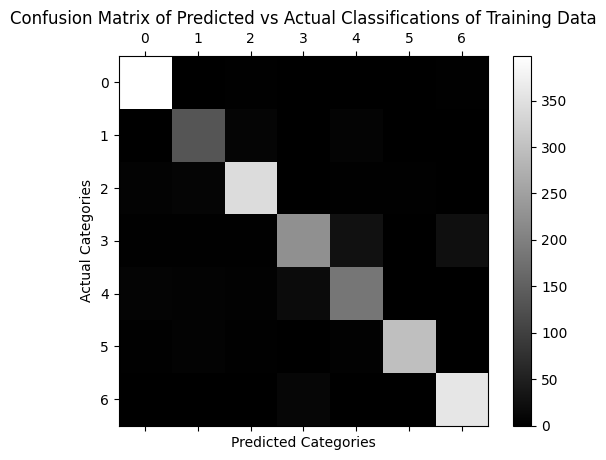

In [15]:
# Plots the confusion matrix to better visualize.
# Generally, the test data was classified correctly given the lighter colors in the diagonal.
fig = plt.figure()
ax = fig.add_subplot(111)
plot = ax.matshow(conf_matrix, cmap=plt.cm.gray)
fig.colorbar(plot)
ax.set_xlabel('Predicted Categories')
ax.set_ylabel('Actual Categories')
ax.set_title('Confusion Matrix of Predicted vs Actual Classifications of Training Data')

plt.show()

In [16]:
## 1. For each receipt we will take the avg(vendor embeddings, item1 embeddings, item2 embeddings, ...).
## 2. Pre-process the data to be put into the model.
## 3. Predict using the model.

In [17]:
def compute_embeddings(receipt):
    """Computes the embeddings for the vendor and items in the given receipt."""
    # Converts the receipt to JSON.
    try:
        json_object = json.loads(receipt)
    except:
        return None, None
    
    # Gets the vendor name from the receipt JSON object.
    vendor = json_object['ReceiptInfo']['merchant']
    embeddings_model = HuggingFaceEmbeddings()

    if vendor != "":
        # Gets embeddings for the vendor.
        vendor_embeddings = embeddings_model.embed_documents(vendor)[0]
    else:
        vendor_embeddings = None
    
    # Gets embeddings for items in receipt.
    items = [item['description'] for item in json_object['ReceiptInfo']['ITEMS']]
    embedded_items = embeddings_model.embed_documents(items)

    return vendor_embeddings, embedded_items

In [18]:
def get_avg_embeddings(vendor_embeddings, embedded_items):
    """Gets the average receipt embeddings"""
    avg_embeddings = []
    receipt_embeddings = {}

    if embedded_items is None and vendor_embeddings is None:
        return None
    elif len(embedded_items) == 0 and vendor_embeddings is not None:
        avg_embeddings = vendor_embeddings
    elif len(embedded_items) == 0 and vendor_embeddings is None:
        return None
    else:
        # For each embedding for the vendor.
        for i in range(len(embedded_items[0])):
    
            if vendor_embeddings is not None:
                # Add the embedding to embeddings.
                embeddings = [vendor_embeddings[i]]
            else:
                embeddings = []
        
            # Add all corresponding item embeddings to embeddings.
            for item_embedding in embedded_items:
                embeddings.append(item_embedding[i])
        
            # Add the average of the embedding to average embeddings.
            avg_embeddings.append(np.average(embeddings))
    
    # For each embedding add it to the embeddings object.
    for i in range(len(avg_embeddings)):
        if f'embedding_{i}' in receipt_embeddings:
            receipt_embeddings[f'embedding_{i}'].append(avg_embeddings[i])
        else:
            receipt_embeddings[f'embedding_{i}'] = []
            receipt_embeddings[f'embedding_{i}'].append(avg_embeddings[i])
    
    return receipt_embeddings

In [19]:
predicted_categories = []
category_counts = {}

# Gets a category prediction for each receipt.
for receipt in receipt_outputs:
    vendor_embeddings, embedded_items = compute_embeddings(receipt)
    avg_embeddings = get_avg_embeddings(vendor_embeddings, embedded_items)

    if avg_embeddings is not None:
        receipt_embeddings = pd.DataFrame(avg_embeddings)
        pred_category = knn_cls.predict(receipt_embeddings.to_numpy())[0]
        predicted_categories.append(pred_category)

    # Updates counts for categories predicted.
    if pred_category in category_counts:
        category_counts[pred_category] += 1
    else:
        category_counts[pred_category] = 1

2023-12-13 21:08:08 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:09 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:09 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:10 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:10 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:11 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:11 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:12 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:12 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:12 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:13 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:13 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:14 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:14 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:14 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:15 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:15 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:16 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:16 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:17 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 0it [00:00, ?it/s]

2023-12-13 21:08:17 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:18 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:18 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:19 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:19 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:20 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:20 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:21 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:21 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:22 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:22 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:23 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:23 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:24 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 0it [00:00, ?it/s]

2023-12-13 21:08:24 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:24 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:08:25 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:25 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Visualization of Vendors

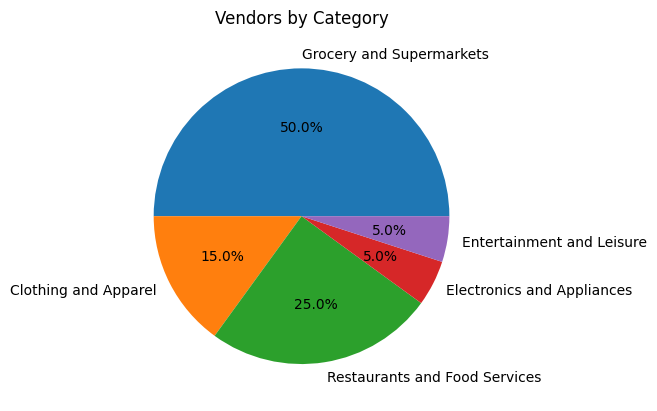

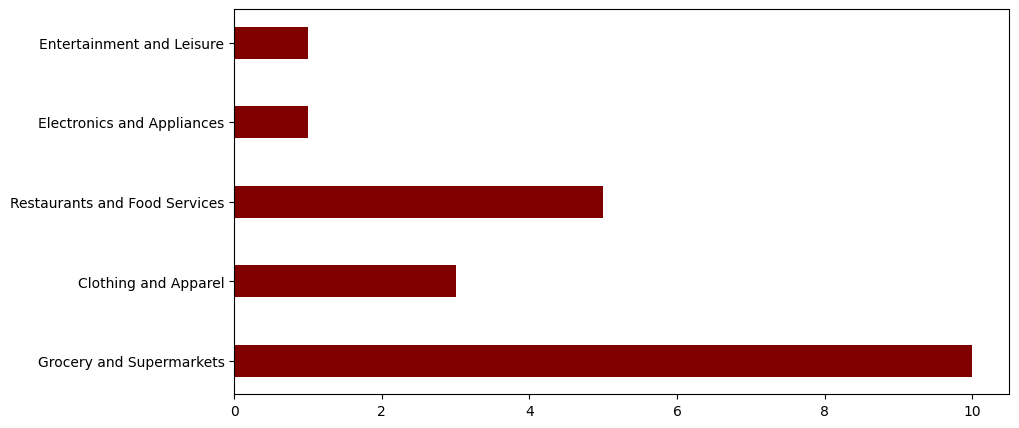

In [20]:
import matplotlib.pyplot as plt

#pie chart for vendor categories
labels = list(category_counts.keys())
values = list(category_counts.values())

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.set_title('Vendors by Category')


#bar graph for vendor categories
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(labels, values, color ='maroon', 
        height = 0.4)

plt.show()

# Product Classification

In [21]:
## Product Classification.

product_categories = ["Produce", "Dairy", "Fast Food", "Fine Dining", "Accessories", "Clothing", "Beauty Products", "Shower Products",
                      "Video Games", "Phones / Tablets", "Appliances", "Tools", "Furniture", "Entertainment and Leisure"]

def get_product_training_data():
    folder_path = 'product_training_data/'
    category_train_test_data = {}
    category_training_items = []
    
    # List all files in the folder
    files = os.listdir(folder_path)
    i = 0

    # Gets the items for each category.
    for category in product_categories:
        # Gets the file identifier for the category.
        category_id = (category.split(" ")[0]).lower()
        file_name = f'{category_id}.txt'
        file_path = os.path.join(folder_path, file_name)
    
        # Check if it's a text file.
        if file_name.endswith('.txt'):
            with open(file_path, 'r') as file:
                # Read the content and split into list by newline character.
                text_content = file.read().split('\n')
                # Adds the items to the category in the dict.
                category_train_test_data[product_categories[i]] = text_content
                i += 1
    return category_train_test_data

prod_category_train_test_data = get_product_training_data()
prod_category_training_embeddings = {}

embeddings_model = HuggingFaceEmbeddings()

for category in prod_category_train_test_data:
    prod_category_training_embeddings[category] = embeddings_model.embed_documents(prod_category_train_test_data[category])
    
len(prod_category_training_embeddings["Produce"]), len(prod_category_training_embeddings)

2023-12-13 21:08:26 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:08:27 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

(50, 14)

In [22]:
df_prod_category_items = []
d = {'categories':[]}

# Each category.
for category in prod_category_training_embeddings:
    # Each item in the category.
    for item in prod_category_training_embeddings[category]:
        df_prod_category_items.append(category)

        # Each embedding in an item.
        for i in range(len(item)):
            embedding = item[i]

            if f'embedding_{i}' in d:
                d[f'embedding_{i}'].append(embedding)
            else:
                d[f'embedding_{i}'] = []
                d[f'embedding_{i}'].append(embedding)

d['categories'] = df_prod_category_items
    
# Training and Testing data.
prod_category_data = pd.DataFrame(d)

prod_category_data.head()

,categories,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,Produce,0.000589,0.003567,-0.036941,-0.022206,0.002603,-0.011552,-0.024489,0.017725,0.035810,...,-0.060234,0.005869,0.038782,-0.017440,-0.002367,0.029283,0.004650,0.016896,0.004629,-0.008035
1,Produce,0.031964,0.005566,-0.023185,-0.053126,0.033858,-0.023757,-0.014453,0.007992,0.017826,...,-0.015866,-0.009298,-0.032220,-0.010490,0.004321,-0.033006,-0.023620,0.016731,-0.022331,-0.015998
2,Produce,0.064584,0.002496,-0.011188,-0.012615,0.030300,0.005024,-0.016991,0.045369,-0.023226,...,-0.051416,-0.021503,-0.000338,-0.001392,0.015543,0.065568,-0.014487,0.009346,-0.026118,-0.021456
3,Produce,0.007646,0.017002,-0.032329,-0.008278,-0.005862,0.004103,-0.004070,0.058659,0.059897,...,-0.021869,-0.005231,0.022821,-0.039141,0.001739,0.050639,0.011290,-0.035887,-0.014058,-0.038552
4,Produce,0.023380,0.070649,-0.030624,-0.020164,0.012016,-0.025285,0.023886,0.039508,0.047931,...,-0.036294,-0.010979,-0.019659,-0.026347,-0.010648,0.019826,-0.008819,0.004444,-0.032169,-0.018519


In [23]:
# Randomly shuffles the rows.
shuffled_data = prod_category_data.sample(frac=1)

total_rows = shuffled_data.shape[0]
train_size = int(total_rows*0.8)
 
# Split data into test and train
train = shuffled_data[0:train_size]
test = shuffled_data[train_size:]

train.head()

,categories,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
284,Clothing,-0.003771,0.040027,-0.012827,-0.066668,-0.048151,-0.016963,-0.003350,0.004367,-0.050957,...,-0.074854,-0.010125,0.029604,-0.016726,-0.002423,0.010775,0.026868,0.004774,-0.003620,-0.018482
339,Beauty Products,-0.025901,-0.164656,0.016607,-0.019543,-0.030505,-0.029449,-0.014532,-0.011301,0.025669,...,-0.013054,-0.016385,-0.053330,-0.016849,0.005187,0.016689,0.042287,0.022827,-0.100304,0.023654
314,Beauty Products,0.043754,-0.006187,0.011134,-0.041920,-0.026595,0.001054,-0.014206,0.036285,0.016780,...,-0.051375,-0.018626,0.012770,0.005182,0.005965,-0.107572,-0.031738,-0.005800,-0.088764,-0.033939
538,Appliances,-0.009275,-0.038251,-0.017262,-0.020477,-0.044943,0.022553,0.021590,0.033648,0.059369,...,0.024097,-0.055298,0.115589,-0.003068,0.010510,0.014839,0.025836,-0.022722,-0.094302,-0.023298
480,Phones / Tablets,-0.017700,-0.091788,0.012540,0.045479,0.023606,-0.006602,0.005575,-0.030289,0.014377,...,0.001157,0.021384,0.061063,-0.031992,0.008729,0.015117,0.016179,0.018254,0.004192,0.018996


In [24]:
# X is the embeddings and Y is the product categories.

y_train = train['categories']
x_train = train.loc[:, train.columns != 'categories']

y_test = test['categories']
x_test = test.loc[:, test.columns != 'categories']

In [25]:
knn = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors.
param_grid = {'n_neighbors': np.arange(1, 25)}

# Uses gridsearch to test all values for n_neighbors.
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data.
knn_grid_search.fit(x_train, y_train)

# Gets the n_neighbors value which warrants the highest accuracy.
best_n_neighbors=knn_grid_search.best_params_['n_neighbors']
best_n_neighbors

10

In [26]:
# Trains the KNN model with the best n_neighbors value.
knn_cls_prod = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_cls_prod.fit(x_train.values, y_train.values)

KNeighborsClassifier(n_neighbors=10)

In [27]:
from sklearn.metrics import confusion_matrix

# Gets the predications for the test dataset.
y_test_pred = knn_cls_prod.predict(x_test.values)

# Gets a confusion matrix for error analysis.
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[ 7,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 2,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  0,  1,  1,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  2,  0,  8,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  3, 10,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  1,  0,  1,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 2,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  9,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6]])

In [28]:
# Gets precision, recall, and f1 score from the test data.
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='micro')
recall = recall_score(y_test, y_test_pred, average='micro')
# f1 = f1_score(y_test, y_test_pred, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).')
print(f'Recall: {recall}. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).')
# print(f'F1 Score: {f1}. This high score means the model is relatively good at classifiying.')

Accuracy: 0.7391304347826086
Precision: 0.7391304347826086. This high ratio assumes most postives were true positives since precision = tp / (tp + fp).
Recall: 0.7391304347826086. This high ratio means there were not too many false negatives since recalle = tp / (tp + fn).


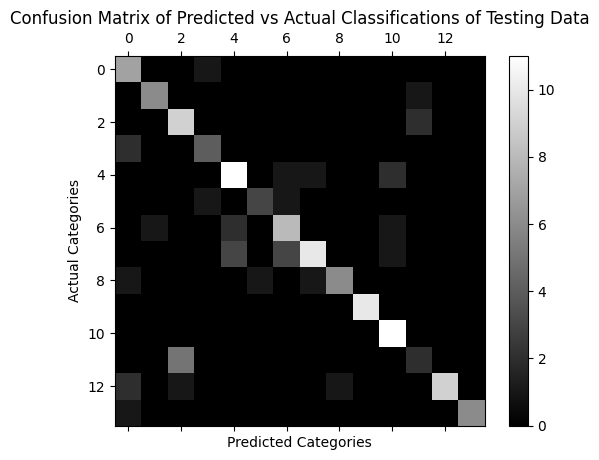

In [29]:
# Plots the confusion matrix to better visualize.
# Generally, the test data was classified correctly given the lighter colors in the diagonal.
# However some misclassifications.
fig = plt.figure()
ax = fig.add_subplot(111)
plot = ax.matshow(conf_matrix, cmap=plt.cm.gray)
fig.colorbar(plot)
ax.set_xlabel('Predicted Categories')
ax.set_ylabel('Actual Categories')
ax.set_title('Confusion Matrix of Predicted vs Actual Classifications of Testing Data')

plt.show()

In [30]:
test_items = ["Happy Meal Ch Burger", "MARINARA SCE", "HT VEGE DUMPLING"]

def compute_item_embeddings(item):
    embeddings_model = HuggingFaceEmbeddings()
    item_name = item['description']
    item_embeddings_obj = {}
    
    if item_name != "":
        # Gets embeddings for the item.
        item_embeddings = embeddings_model.embed_documents(item_name)[0]

        for i in range(len(item_embeddings)):
            if f'embeddings_{i}' in item_embeddings_obj:
                item_embeddings_obj[f'embeddings_{i}'].append(item_embeddings[i])
            else:
                item_embeddings_obj[f'embeddings_{i}'] = []
                item_embeddings_obj[f'embeddings_{i}'].append(item_embeddings[i])

    return item_embeddings_obj

In [33]:
product_predicted_categories = []
product_category_counts = {}

# Classifies category for each item in each receipt.
for receipt in receipt_outputs:
    try:
        json_obj = json.loads(receipt)
        if 'ITEMS' in json_obj['ReceiptInfo']:
            for item in json_obj['ReceiptInfo']['ITEMS']:
                item_df = pd.DataFrame(compute_item_embeddings(item))
                pred_prod_category = knn_cls_prod.predict(item_df.values)[0]
                product_predicted_categories.append(pred_prod_category)
    
                # Keeps count of each category.
                if pred_prod_category in product_category_counts:
                    product_category_counts[pred_prod_category] += 1
                else:
                    product_category_counts[pred_prod_category] = 1
    except:
        pass

2023-12-13 21:10:58 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:10:59 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:10:59 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:00 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-12-13 21:11:00 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:01 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:01 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:02 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-12-13 21:11:02 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:03 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:03 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:03 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:04 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:04 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:04 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:05 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:05 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:06 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:06 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:07 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:07 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:08 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:08 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:09 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:09 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:09 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:10 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:10 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:10 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:11 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:11 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:12 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:12 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:13 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:13 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:14 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:14 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:15 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:15 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:15 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:16 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:16 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:16 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:17 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:17 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:18 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:18 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:19 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:19 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:20 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:20 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:21 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:21 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:21 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:21 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:22 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:22 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:23 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:23 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:24 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:24 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:25 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:25 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:26 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:26 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:27 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:27 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:27 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:27 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:28 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:28 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:29 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:29 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:30 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:30 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:31 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:31 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:32 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:32 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:33 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:33 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:34 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:34 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:34 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:35 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:35 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:35 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:36 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:36 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:37 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:37 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:38 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:38 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:39 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:39 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:40 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:40 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:41 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:41 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:42 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:42 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:43 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:43 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:43 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:44 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:44 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:44 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:45 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:45 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:46 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:46 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:47 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:47 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:48 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-13 21:11:48 sentence_transformers.SentenceTransformer INFO: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-12-13 21:11:49 sentence_transformers.SentenceTransformer INFO: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Product Visualization

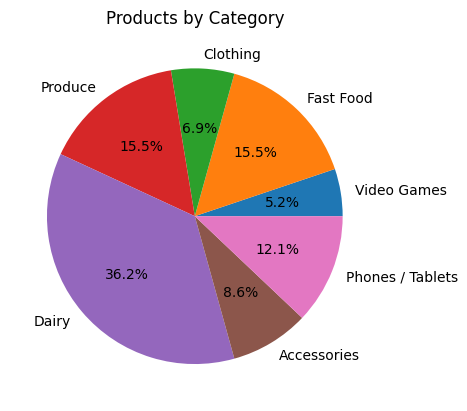

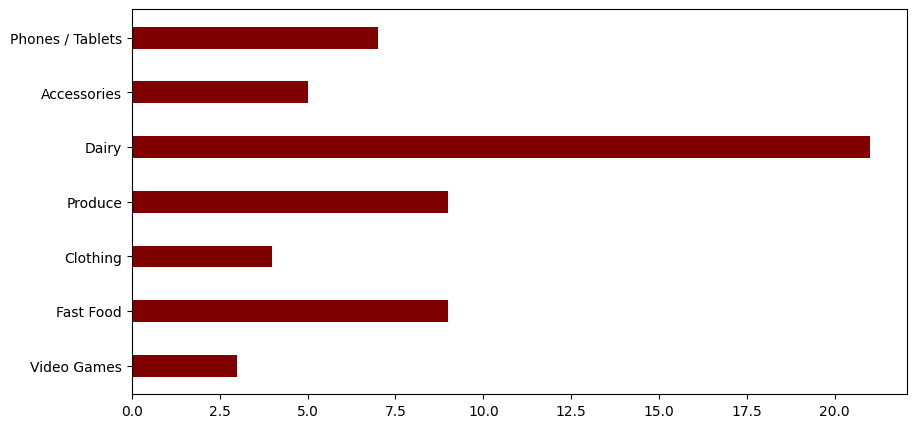

In [34]:
import matplotlib.pyplot as plt

#pie chart for vendor categories
labels = list(product_category_counts.keys())
values = list(product_category_counts.values())

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.set_title('Products by Category')


#bar graph for vendor categories
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(labels, values, color ='maroon', 
        height = 0.4)

plt.show()

# Named Entity Recognition (Nervaluate)

In [35]:
## Named Entity Recognition:
def find_span(text, entity_text):
    """Finds the start and end positions for a given entity_text"""
    start = text.find(entity_text)
    if start == -1:
        return None
    end = start + len(entity_text)
    return (start, end), entity_text

def convert_to_prodigy_spans(receipt_text, entities):
    """Structures the receipt data by finding the position spans of each field indicated in the Structured JSON Object."""
    text_vals = []
    entities = json.loads(entities)
    prodigy_data = []
    receipt_info = entities["ReceiptInfo"]

    # Gets the label and entity_text for each corresponding label and entity listed.
    for label, entity_text in [
        ("MERCHANT", str(receipt_info.get("merchant", ""))), 
        ("ADDRESS", str(receipt_info.get("address", ""))), 
        ("CITY", str(receipt_info.get("city", ""))), 
        ("STATE", str(receipt_info.get("state", ""))), 
        ("PHONE", str(receipt_info.get("phoneNumber", ""))), 
        ("TAX", str(receipt_info.get("tax", ""))), 
        ("TOTAL", str(receipt_info.get("total", ""))), 
        ("DATE", str(receipt_info.get("receiptDate", ""))) 
    ]:

        # Tries to add positions of enties for corresponding labels.
        #try:
        if entity_text:
            span = find_span(receipt_text, entity_text)
            if span:
                stend, text = span
                text_vals.append(text)
                start, end = stend
                prodigy_data.append([{"start": start, "end": end, "label": label}])
            else:
                # if span is not found, assume the value is not in the raw text
                prodigy_data.append([{"start": 0, "end": 0, "label": label}])
        #except:
         #   continue

    # Process item-level entities
    item_num = 1
    for item in receipt_info["ITEMS"]:
        for label, entity_text in [  
            ("ITEM_DESC", item.get("description", "")),
            ("QTY", str(item.get("quantity", ""))),
            ("UNIT_PRICE", str(item.get("unitPrice", ""))),
            ("TOTAL_PRICE", str(item.get("totalPrice", ""))),
            ("DISCOUNT", str(item.get("discountAmount", "")))  # Discount might not always be present
        ]:
            if entity_text:  # Check if the entity text is not empty
                span = find_span(receipt_text, entity_text)
                if span:
                    stend, text = span
                    text_vals.append(text)
                    start, end = stend
                    prodigy_data.append([{"start": start, "end": end, "label": label + str(item_num)}])
                else:
                    # if span is not found, assume the value is not in the raw text
                    prodigy_data.append([{"start": 0, "end": 0, "label": label + str(item_num)}])
        item_num += 1

    return prodigy_data, text_vals

# Example usage

#prodigy_spans_true, text_vals = convert_to_prodigy_spans(test_receipts[0], receipt_outputs[0])
#print(json.dumps(prodigy_spans_true, indent=2))

In [36]:
def get_prodigy_spans(text, true_ents, pred_ents):
    # Get the Prodigy spans for the manually parsed entities
    prodigy_spans_true, text_vals = convert_to_prodigy_spans(text, true_ents)
    labels_true = list(span[0]["label"] for span in prodigy_spans_true)
    # Get the Prodigy spans for the LangChain generated entities
    prodigy_spans_predicted, text_vals_predicted = convert_to_prodigy_spans(text, pred_ents)
    labels_predicted = list(span[0]["label"] for span in prodigy_spans_predicted)
    
    evaluator = Evaluator(prodigy_spans_true, prodigy_spans_predicted, tags=labels_true)

    # Returns overall metrics and metrics for each tag

    results, results_per_tag = evaluator.evaluate()

    print(results)

In [37]:
# Raw text data from zip file
test_text_1 = '''
SAFEWAY O
<UNKNOWN>
Store 205 Dir Betsy Esposito
Main : (808) 266-5200
1060 Keolu Drive
KAILUA HI 96734
GROCERY
BODY ARMOR
9.99 B
DEP SFTDK 8 PK FS
0.40 S
FEE SFTDK 8 PK FS
0.08 S
Regular Price 11.49
Member Savings
1.50-
TAX
0.47
**** BALANCE
10.94
'''

# True values that were manually parsed
test_true_1 = '''
{
  "ReceiptInfo": {
    "merchant": "SAFEWAY",
    "address": "1060 Keolu Drive",
    "city": "KAILUA",
    "state": "HI",
    "phoneNumber": "(808) 266-5200",
    "tax": "0.47",
    "total": "10.94",
    "receiptDate": "",
    "receiptTime": "",


    "ITEMS": [
      {
        "description": "BODY ARMOR",
        "quantity": "1",
        "unitPrice": "9.99",
        "totalPrice": "9.99",
        "discountAmount": "0.00"
      },
      {
        "description": "DEP SFTDK 8 PK FS",
        "quantity": "1",
        "unitPrice": "0.40",
        "totalPrice": "0.40",
        "discountAmount": "0.00"
      },
      {
        "description": "FEE SFTDK 8 PK FS",
        "quantity": "1",
        "unitPrice": "0.08",
        "totalPrice": "0.08",
        "discountAmount": "0.00"
      }
    ]
  }
}
'''

# Output returned by ChatGPT/LangChain
test_pred_1 = '''
{
"ReceiptInfo": {
"merchant": "SAFEWAY",
"address": "1060 Keolu Drive",
"city": "KAILUA",
"state": "HI",
"phoneNumber": "(808) 266-5200",
"tax": "0.47",
"total": "10.94",
"receiptDate": "",
"receiptTime": "",
"ITEMS": [
{
"description": "BODY ARMOR",
"quantity": "1",
"unitPrice": "9.99",
"totalPrice": "9.99",
"discountAmount": "0.00"
},
{
"description": "DEP SFTDK 8 PK FS",
"quantity": "1",
"unitPrice": "0.40",
"totalPrice": "0.40",
"discountAmount": "0.00"
},
{
"description": "FEE SFTDK 8 PK FS",
"quantity": "1",
"unitPrice": "0.08",
"totalPrice": "0.08",
"discountAmount": "0.00"
}
]
}
}
'''

get_prodigy_spans(test_text_1, test_true_1, test_pred_1)

{'ent_type': {'correct': 22, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 22, 'actual': 22, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'partial': {'correct': 22, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 22, 'actual': 22, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'strict': {'correct': 22, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 22, 'actual': 22, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'exact': {'correct': 22, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 22, 'actual': 22, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}


In [38]:
test_text_2 = '''
Sam's Club #6410
1000 KAMEHAMEHA HWY STE
PEARL CITY, HI 96782
Pump# 24 UNLEAD (11)
Gallons
15.326
Price/Gal
$4.189
Fuel Sale
$64.20
Discover Credit $64.20
DS
<UNKNOWN> I
01
Auth:
<UNKNOWN>
Apprvl :
01796R
AID #A0000001523010
07/17/23 12:01 PM
TC#
<UNKNOWN>'''

test_true_2 = '''
{
  "ReceiptInfo": {
    "merchant": "Sam's Club",
    "address": "1000 KAMEHAMEHA HWY",
    "city": "PEARL CITY",
    "state": "HI",
    "phoneNumber": "",
    "tax": "0.00",
    "total": "64.20",
    "receiptDate": "07/17/23",
    "receiptTime": "12:01 PM",


    "ITEMS": [
      {
        "description": "UNLEAD",
        "quantity": "15.326",
        "unitPrice": "4.189",
        "totalPrice": "64.20",
        "discountAmount": "0.00"
      }
    ]
  }
}
'''

test_pred_2 = '''
{
"ReceiptInfo": {
"merchant": "Sam's Club #6410",
"address": "1000 KAMEHAMEHA HWY STE",
"city": "PEARL CITY",
"state": "HI",
"phoneNumber": "",
"tax": "0.00",
"total": "64.20",
"receiptDate": "07/17/23",
"receiptTime": "12:01 PM",
"ITEMS": [
{
"description": "UNLEAD",
"quantity": "15.326",
"unitPrice": "4.189",
"totalPrice": "64.20",
"discountAmount": "0.00"
}
]
}
}'''

get_prodigy_spans(test_text_2, test_true_2, test_pred_2)

{'ent_type': {'correct': 12, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 12, 'actual': 12, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'partial': {'correct': 10, 'incorrect': 0, 'partial': 2, 'missed': 0, 'spurious': 0, 'possible': 12, 'actual': 12, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666}, 'strict': {'correct': 10, 'incorrect': 2, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 12, 'actual': 12, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1': 0.8333333333333334}, 'exact': {'correct': 10, 'incorrect': 2, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 12, 'actual': 12, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1': 0.8333333333333334}}


In [39]:
test_text_3 = '''
LILIHA BAKERY <UNKNOWN> PEARL CITY
Pearl Highlands Center
Pearl City, HI 96782
(808)455-1188
Check 375997/1 Cashier: POS1 AM
10/21/2023 5:46:41 PM
Bakery
10
Poi Donut
20.90
1
Coco Puff 6
12.50
6
Green Tea Puff
13.74
SUB TOTAL
47.14
Sales Tax
2.22
TOTAL
49.36
'''

test_true_3 = '''
{
  "ReceiptInfo": {
    "merchant": "LILIHA BAKERY",
    "address": "Pearl Highlands Center",
    "city": "Pearl City",
    "state": "HI",
    "phoneNumber": "(808)455-1188",
    "tax": "2.22",
    "total": "49.36",
    "receiptDate": "10/21/2023",
    "receiptTime": "5:46:41 PM",


    "ITEMS": [
      {
        "description": "Poi Donut",
        "quantity": "10",
        "unitPrice": "2.09",
        "totalPrice": "20.90",
        "discountAmount": "0.00"
      },
      {
        "description": "Coco Puff",
        "quantity": "6",
        "unitPrice": "2.08",
        "totalPrice": "12.50",
        "discountAmount": "0.00"
      },
      {
        "description": "Green Tea Puff",
        "quantity": "6",
        "unitPrice": "2.29",
        "totalPrice": "13.74",
        "discountAmount": "0.00"
      }
    ]
  }
}'''

test_pred_3 = '''
{
"ReceiptInfo": {
"merchant": "LILIHA BAKERY",
"address": "Pearl Highlands Center, Pearl City, HI 96782",
"city": "Pearl City",
"state": "HI",
"phoneNumber": "(808)455-1188",
"tax": "2.22",
"total": "49.36",
"receiptDate": "10/21/2023",
"receiptTime": "5:46:41 PM",
"ITEMS": [
{
"description": "Poi Donut",
"quantity": "10",
"unitPrice": "20.90",
"totalPrice": "20.90",
"discountAmount": "0.00"
},
{
"description": "Coco Puff",
"quantity": "1",
"unitPrice": "12.50",
"totalPrice": "12.50",
"discountAmount": "0.00"
},
{
"description": "Green Tea Puff",
"quantity": "6",
"unitPrice": "13.74",
"totalPrice": "13.74",
"discountAmount": "0.00"
}
]
}
}'''

get_prodigy_spans(test_text_3, test_true_3, test_pred_3)

{'ent_type': {'correct': 18, 'incorrect': 0, 'partial': 0, 'missed': 5, 'spurious': 5, 'possible': 23, 'actual': 23, 'precision': 0.782608695652174, 'recall': 0.782608695652174, 'f1': 0.782608695652174}, 'partial': {'correct': 18, 'incorrect': 0, 'partial': 0, 'missed': 5, 'spurious': 5, 'possible': 23, 'actual': 23, 'precision': 0.782608695652174, 'recall': 0.782608695652174, 'f1': 0.782608695652174}, 'strict': {'correct': 18, 'incorrect': 0, 'partial': 0, 'missed': 5, 'spurious': 5, 'possible': 23, 'actual': 23, 'precision': 0.782608695652174, 'recall': 0.782608695652174, 'f1': 0.782608695652174}, 'exact': {'correct': 18, 'incorrect': 0, 'partial': 0, 'missed': 5, 'spurious': 5, 'possible': 23, 'actual': 23, 'precision': 0.782608695652174, 'recall': 0.782608695652174, 'f1': 0.782608695652174}}


In [40]:
test_text_4 = '''
KOZO SUSHI
Kozo Sushi - Moilili
2334 South King Street
Honolulu, HI 96826
Take Out
Server: Manager P
Check #101
Ordered :
4/7/23 3:36 PM
2 Cucumber Maki
$3.98
1 Shrimp Tempura Hr
$3.30
Subtotal
$7.28
Tax
$0.33
Total
$7.61
Cash Tendered
$20.00
Change
$12.39
Powered by Toast'''

test_true_4 = '''
{
  "ReceiptInfo": {
    "merchant": "KOZO SUSHI",
    "address": "2334 South King Street",
    "city": "Honolulu",
    "state": "HI",
    "phoneNumber": "",
    "tax": "0.33",
    "total": "7.61",
    "receiptDate": "4/7/23",
    "receiptTime": "3:36 PM",


    "ITEMS": [
      {
        "description": "Cucumber Maki",
        "quantity": "2",
        "unitPrice": "1.99",
        "totalPrice": "3.98",
        "discountAmount": "0.00"
      },
      {
        "description": "Shrimp Tempura Hr",
        "quantity": "1",
        "unitPrice": "3.30",
        "totalPrice": "3.30",
        "discountAmount": "0.00"
      }
    ]
  }
}
'''

test_pred_4 = '''
{
"ReceiptInfo": {
"merchant": "KOZO SUSHI",
"address": "2334 South King Street",
"city": "Honolulu",
"state": "HI",
"phoneNumber": "",
"tax": "0.33",
"total": "7.61",
"receiptDate": "4/7/23",
"receiptTime": "3:36 PM",
"ITEMS": [
{
"description": "Cucumber Maki",
"quantity": "2",
"unitPrice": "3.98",
"totalPrice": "3.98",
"discountAmount": "0.00"
},
{
"description": "Shrimp Tempura Hr",
"quantity": "1",
"unitPrice": "3.30",
"totalPrice": "3.30",
"discountAmount": "0.00"
}
]
}
}'''

get_prodigy_spans(test_text_4, test_true_4, test_pred_4)

{'ent_type': {'correct': 16, 'incorrect': 0, 'partial': 0, 'missed': 1, 'spurious': 1, 'possible': 17, 'actual': 17, 'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1': 0.9411764705882353}, 'partial': {'correct': 16, 'incorrect': 0, 'partial': 0, 'missed': 1, 'spurious': 1, 'possible': 17, 'actual': 17, 'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1': 0.9411764705882353}, 'strict': {'correct': 16, 'incorrect': 0, 'partial': 0, 'missed': 1, 'spurious': 1, 'possible': 17, 'actual': 17, 'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1': 0.9411764705882353}, 'exact': {'correct': 16, 'incorrect': 0, 'partial': 0, 'missed': 1, 'spurious': 1, 'possible': 17, 'actual': 17, 'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1': 0.9411764705882353}}


In [41]:
test_text_5 = '''
Hardware
Hawaii
CONTRACTOR'S
CHOICE
THANK YOU FOR SHOPPING AT
<UNKNOWN> Hawaii Kailua
30 Kihapai Street
Kailua, Hawaii 96734
www.hardwarehawaii.com
(808) 266-1133
Kailua
10/07/23 10:30AM 1013
106
SALE
QC
1 BG
$10.25 BG
CONCRETE MIX 60lb QUIKRETE
$10.25
SUB-TOTAL:$
10.25 TAX:
$
.48
TOTAL: $
10.73
BC <UNKNOWN>
$
10.73'''

test_true_5 = '''
{
  "ReceiptInfo": {
    "merchant": "Hardware Hawaii",
    "address": "30 Kihapai Street",
    "city": "Kailua",
    "state": "Hawaii",
    "phoneNumber": "(808) 266-1133",
    "tax": "0.48",
    "total": "10.73",
    "receiptDate": "10/07/23",
    "receiptTime": "10:30AM",


    "ITEMS": [
      {
        "description": "CONCRETE MIX 60lb QUIKRETE",
        "quantity": "1",
        "unitPrice": "10.25",
        "totalPrice": "10.25",
        "discountAmount": "0.00"
      }
    ]
  }
}
'''

test_pred_5 = '''
{
"ReceiptInfo": {
"merchant": "Hardware Hawaii",
"address": "30 Kihapai Street",
"city": "Kailua",
"state": "Hawaii",
"phoneNumber": "(808) 266-1133",
"tax": "0.48",
"total": "10.73",
"receiptDate": "10/07/23",
"receiptTime": "10:30AM",
"ITEMS": [
{
"description": "CONCRETE MIX 60lb QUIKRETE",
"quantity": "1",
"unitPrice": "10.25",
"totalPrice": "10.25",
"discountAmount": "0.00"
}
]
}
}'''

get_prodigy_spans(test_text_5, test_true_5, test_pred_5)

{'ent_type': {'correct': 13, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 13, 'actual': 13, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'partial': {'correct': 13, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 13, 'actual': 13, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'strict': {'correct': 13, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 13, 'actual': 13, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'exact': {'correct': 13, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 13, 'actual': 13, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}
